# 프로젝트 : 폐렴 진단기 성능개선

## library import

In [1]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

## model 훈련 셋팅

In [24]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel/AIFFEL_LSG/utill')

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [200, 200]

# EPOCH 크기 변수
EPOCHS = 30

print(ROOT_PATH)


/home/aiffel0042/aiffel/AIFFEL_LSG/utill


## data load

In [25]:
#파일 이름 리스트만 .후루룩

train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

## data train data 부족으로 val 데이터랑 합치고 다시 나눔.....

5216
624
16


In [26]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))
# 붙이고 확장.

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2) # 다시 나눔.....

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [27]:
# 이미지 중 정상 이미지와 페렴 이미지  개수 확인

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

## 데이터는 불균형함.... 

Normal images count in training set: 1067
Pneumonia images count in training set: 3118


## data 처리.
- 라벨. 붙이기
- tf 
- 

In [28]:
## 파일이름리스트 tf.data. instace로 볂환 처리 8282
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [29]:
## 갯수 구해놓기 미리 나중에 imbalance 위해

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [30]:
## 함수 정의

# label getter FN
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.


## 이미지 조정, 사이즈 조절float 형변환
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

# 진행 함수(main)
def process_path(file_path):
    label = get_label(file_path) # 라벨 구해오고
    img = tf.io.read_file(file_path) # 이미지 읽어오고
    img = decode_img(img) # 이미지 조정하고
    return img, label

In [31]:
# train data, valdation data  진행

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)


In [32]:
# test data 도 

test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


## data augmentation

In [33]:
# augment 함수

def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    
    return image,label



def prepare_for_training(ds, shuffle_buffer_size=1000):
    ##########################################################################
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ####################################################################
    
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) # 고정 크기 버퍼 유지하고 해당 버퍼에서 무작위 료 균일하기 다음 ㅇ요소 선택

    ds = ds.repeat() #  epoch 진행 시 여러번 데이터셋을 사용할 수 있게 해줌.

    ds = ds.batch(BATCH_SIZE) # batch size 만큼 batch 나눔.

    ds = ds.prefetch(buffer_size=AUTOTUNE) # 첫번째 데이터를 GPU에서 학습하는 동안 두번째 데이터를 cpu에서 준비시킴.


    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## train data 시각화

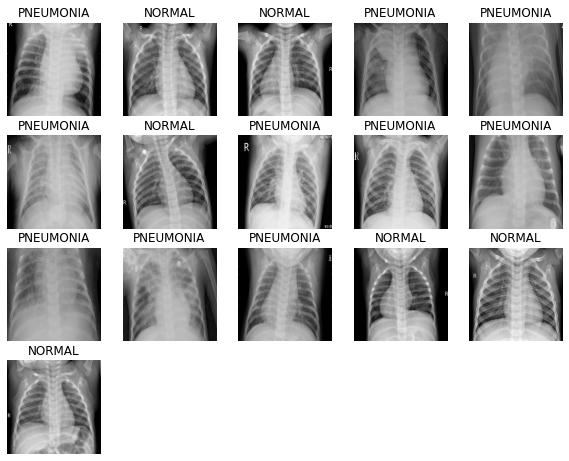

In [34]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

## cnn model

In [35]:
### conv layer block build 함수 선언

In [36]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [37]:
### dense block 함수
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [38]:
### model build fn
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## data imbalance 처리

In [39]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.96
Weight for class 1: 0.67


## model train

In [40]:
## gpu 설정
## 이미지 라벨이 2개 이기에 loss 를 binary_cross_entropy 사용
# 성과 측정 metrics으로 'accuracy', 'precision', 'recall'
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [41]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/30
261/261 [==============================] - 27s 104ms/step - loss: 0.3720 - accuracy: 0.8261 - precision: 0.9540 - recall: 0.8056 - val_loss: 0.7371 - val_accuracy: 0.7308 - val_precision: 0.7308 - val_recall: 1.0000
Epoch 2/30
261/261 [==============================] - 24s 93ms/step - loss: 0.2673 - accuracy: 0.9001 - precision: 0.9697 - recall: 0.8939 - val_loss: 1.2830 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 3/30
261/261 [==============================] - 23s 90ms/step - loss: 0.2182 - accuracy: 0.9155 - precision: 0.9726 - recall: 0.9123 - val_loss: 0.3369 - val_accuracy: 0.8288 - val_precision: 0.8107 - val_recall: 0.9987
Epoch 4/30
261/261 [==============================] - 25s 97ms/step - loss: 0.2016 - accuracy: 0.9255 - precision: 0.9746 - recall: 0.9242 - val_loss: 0.5665 - val_accuracy: 0.8240 - val_precision: 0.9983 - val_recall: 0.7599
Epoch 5/30
261/261 [==============================] - 27s 102ms/step - loss: 0.1758 - accuracy:

## 결과 확인 및 시각화`

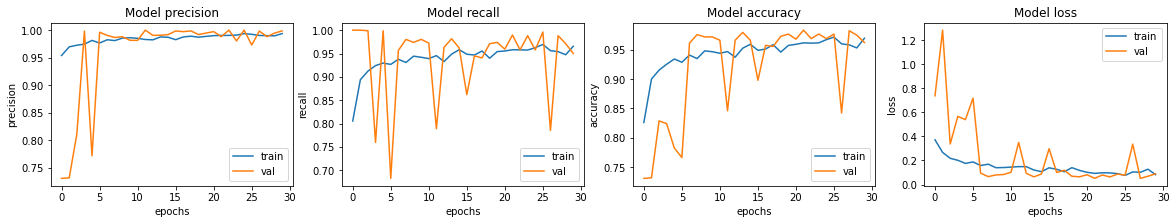

In [43]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
# EPOCH 25 / IMGSIZE 180X180
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 58ms/step - loss: 0.6414 - accuracy: 0.8333 - precision: 0.7955 - recall: 0.9872


In [58]:
# EPOCH 30 / IMGSIZE 200X200
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 61ms/step - loss: 0.6210 - accuracy: 0.8494 - precision: 0.8274 - recall: 0.9590


In [56]:
round(acc, 2)

0.85